# KMINST Classifier using AlexNet
Run all of the numbered sequentially. This notebook produces a AlexNet classifier model.

##1. Functions necessary to use methods in Utils.ipynb
Please run  all of these cells. 

In [0]:
import io, os, sys, types
import nbformat

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [0]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
            
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
      

sys.meta_path.append(NotebookFinder())

### Mount Google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Show that file exists in Google path
**Note**:  You will need to ensure that you have a folder named "**KMNIST_ENTROPY**" in your Google Drive, that contains  Utils.ipynb (and  \__init__.py)

In [4]:
ls gdrive/My\ Drive/KMNIST_ENTROPY

AlexNet.ipynb      __init__.py  Model_Averaging.ipynb  __pycache__/
BEST_PREDICTIONS/  LeNet.ipynb  PCA_Classifier.ipynb   Utils.ipynb


### Append the system path and import Utils.ipynb

In [0]:
sys.path.append('gdrive/My Drive/')

In [6]:
from KMNIST_ENTROPY.Utils import *

# If this cell gives a "No Module Found Error", please restart the runtime of the collab notebook 

importing notebook from gdrive/My Drive/KMNIST_ENTROPY/Utils.ipynb
Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Utils.ipynb has finished downloading


## 2. AlexNet Network Architecture
Running this  network will allow you to train a model using it. If you forget to run the network below, you will not be able to use it for training.

In [7]:
class AlexNet(nn.Module):
  """
    This is an adapted AlexNet neural network to fit the KMNIST dataset.
 
    The activation function used is ReLU
    """
    def __init__(self):
        super(AlexNet,self).__init__()
        self.c1 = nn.Conv2d(1, 8, kernel_size=3,stride=1)
        self.s2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.c3 = nn.Conv2d(8, 16,kernel_size=5, stride= 1, padding=2)
        self.s4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c5 = nn.Conv2d(16, 32, kernel_size=3, stride= 1, padding=1)
        self.c6 = nn.Conv2d(32, 16, kernel_size=2, stride= 1, padding=1)
        self.c7 = nn.Conv2d(16, 32, kernel_size=2, stride= 1, padding=1)
        self.s8 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c9 = nn.Linear(288,288)
        self.d10 = nn.Dropout(0.0)
        self.c11 = nn.Linear(288,288)
        self.d12 = nn.Dropout(0.0)
        self.output = nn.Linear(288,10)
        self.act = nn.ReLU()

    def forward(self,x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = self.act(self.c5(x))
        x = self.act(self.c6(x))
        x = self.act(self.c7(x))
        
        x = self.act(self.s8(x))
        x = x.view(-1, 288)
        x = self.act(self.c9(x))
        x = self.d10(x)
        x = self.act(self.c11(x))
        x = self.d12(x)
        return self.output(x)
      
model = AlexNet()
print(model)

AlexNet(
  (c1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c6): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c7): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (s8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c9): Linear(in_features=288, out_features=288, bias=True)
  (d10): Dropout(p=0.0)
  (c11): Linear(in_features=288, out_features=288, bias=True)
  (d12): Dropout(p=0.0)
  (output): Linear(in_features=288, out_features=10, bias=True)
  (act): ReLU()
)


## 3. Training with optimal hyperparameters
- Optimiser: Adam
- Learning rate: 1e-3
- Number of epochs: 50
- No Dropout
- Random Affine Data Augmentation
- No weight decay

### Train model

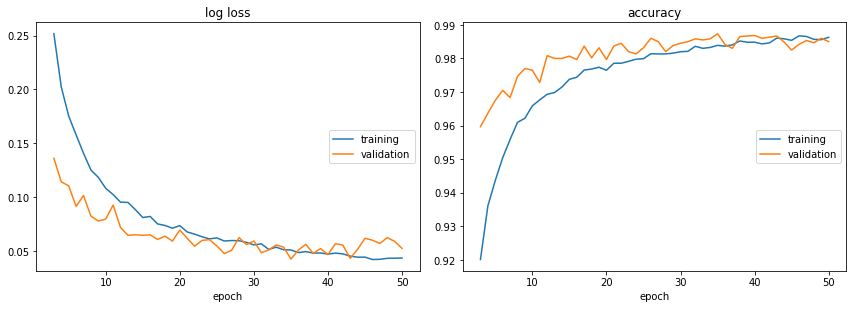

log loss:
training   (min:    0.042, max:    0.870, cur:    0.043)
validation (min:    0.042, max:    0.330, cur:    0.052)

accuracy:
training   (min:    0.697, max:    0.987, cur:    0.986)
validation (min:    0.890, max:    0.987, cur:    0.985)
max training acc: 0.9867222222222222 max validation acc:  0.9873333333333333


In [8]:
# Split
trains, valids, tr_labels, val_labels = k_split(kmnist_data, kmnist_labels, splits=1)

# Mean + std calculation
train_mean, val_mean, train_std, val_std = get_mean_std(trains, valids)

# Dataset
k_train = CustomImageTensorDataset(trains, tr_labels.long(), transform=transformed(train_mean, train_std, choice=2))
k_validate = CustomImageTensorDataset(valids, val_labels.long(), transform=transformed(val_mean, val_std, choice=1))


# Using function train_model_params
params = {'lr':1e-3, 'n_epochs':50, 'optim':'Adam'}
model, tr_a, tr_l, v_a, v_l = train_model_params(model, k_train, k_validate, plot=True, params=params)
print("max training acc:", max(tr_a), "max validation acc: ", max(v_a))

## 4. Save files 
These files can be names whatever you wish, we have just given examples.
### Save testset predictions to csv file 
This saved file will be found in the KMNIST_ENTROPY/results/ folder

In [0]:
save_predictions(model, kmnist_test.float())

### Save model for later use (if needed)
This saved file will be found in the KMNIST_ENTROPY/models/ folder

In [0]:
save_model(model, "AlexNet_optim_model.pth")